In [2]:
import pandas as pd

DATA = pd.read_csv('Bakery sales.csv')
DATA['ticket_number'] = pd.to_numeric(DATA['ticket_number'], downcast='integer')
DATA['at'] = pd.to_datetime(DATA['date'] + ' ' + DATA['time'])
DATA['month'] = DATA['at'].dt.month
DATA['day'] = DATA['at'].dt.weekday
DATA['minute'] = (DATA['at'].dt.hour - 7) * 60 + DATA['at'].dt.minute
DATA = DATA.drop(columns=['Unnamed: 0', 'Quantity', 'unit_price', 'date', 'time', 'at'])
DATA.head()

,ticket_number,article,month,day,minute
0,150040,BAGUETTE,1,5,98
1,150040,PAIN AU CHOCOLAT,1,5,98
2,150041,PAIN AU CHOCOLAT,1,5,134
3,150041,PAIN,1,5,134
4,150042,TRADITIONAL BAGUETTE,1,5,145


In [3]:
TRANSACTIONS = DATA.groupby('ticket_number').agg({'article': list, 'month': 'first', 'day': 'first', 'minute': 'first'})
TRANSACTIONS.head()

,article,month,day,minute
ticket_number,,,,
150040,"[BAGUETTE, PAIN AU CHOCOLAT]",1,5,98
150041,"[PAIN AU CHOCOLAT, PAIN]",1,5,134
150042,[TRADITIONAL BAGUETTE],1,5,145
150043,"[BAGUETTE, CROISSANT]",1,5,145
150044,[BANETTE],1,5,147


In [62]:
import math

def month_distance(a: int, b: int) -> float:
    return min(abs(a - b), 12 - abs(a - b))

def day_distance(a: int, b: int, cluster_size: int, count_of_transactions_with_day: int) -> float:
    if a == b:
        return 1 - count_of_transactions_with_day / cluster_size
    return 1

def distance(a, b, cluster_size: int, count_of_transactions_with_day: int, weight_month: float, weight_minute: float, weight_day: float) -> float:
    return month_distance(a.month, b.month) * weight_month + \
        abs(b.minute - a.minute) * weight_minute + \
        day_distance(a.day, b.day, cluster_size, count_of_transactions_with_day) * weight_day

def clusterize(transactions: pd.DataFrame, k: int, weight_month: float, weight_minute: float, weight_day: float) -> dict:
    centers = transactions.reset_index().sample(k).drop(columns=['ticket_number', 'article']).astype(float)

    # Assign transactions uniformly to clusters.
    clusters = []
    count_of_transactions_per_cluster_per_day = [[0] * 7 for _ in range(k)]
    transactions_per_cluster = (len(transactions) + k - 1) // k
    for i, transaction in enumerate(transactions.itertuples()):
        cluster = i // transactions_per_cluster
        clusters.append(cluster)
        count_of_transactions_per_cluster_per_day[cluster][transaction.day] += 1

    last_sum_of_distances_to_center = None
    sum_of_distances_to_center = math.inf
    
    while last_sum_of_distances_to_center is None or sum_of_distances_to_center < last_sum_of_distances_to_center:
        last_sum_of_distances_to_center = sum_of_distances_to_center
        sum_of_distances_to_center = 0

        for i, transaction in enumerate(transactions.itertuples()):
            min_d = None
            best_center = None

            for j, center in enumerate(centers.itertuples()):
                d = distance(transaction, center, len(transactions), count_of_transactions_per_cluster_per_day[j][transaction.day], weight_month, weight_minute, weight_day)
                if min_d is None or d < min_d:
                    min_d = d
                    best_center = j
            
            sum_of_distances_to_center += min_d
            clusters[i] = best_center

        # Add a cluster column to the transactions DataFrame.
        transactions_with_clusters = transactions.copy()
        transactions_with_clusters['cluster'] = clusters

        for i in range(k):
            transactions_in_cluster = transactions_with_clusters.loc[transactions_with_clusters['cluster'] == i]
            centers.iloc[i].minute = transactions_in_cluster['minute'].median()
            centers.iloc[i].month = transactions_in_cluster['month'].median()
            centers.iloc[i].day = transactions_in_cluster['day'].median()
        
        # Update count_of_transactions_per_cluster_per_day
        count_of_transactions_per_cluster_per_day = [[0] * 7 for _ in range(k)]
        for transaction in transactions_with_clusters.itertuples():
            count_of_transactions_per_cluster_per_day[transaction.cluster][transaction.day] += 1
        
    return centers, clusters

SAMPLES = TRANSACTIONS.sample(1000)
CENTERS, CLUSTERS = clusterize(SAMPLES, 5, 1, 1, 3000)

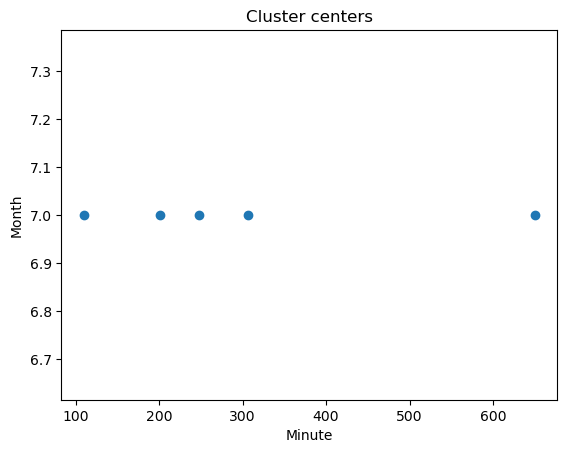

In [60]:
from matplotlib import pyplot as plt

plt.scatter(CENTERS['minute'], CENTERS['month'])
plt.xlabel('Minute')
plt.ylabel('Month')
plt.title('Cluster centers')
plt.show()

<Axes: xlabel='day', ylabel='minute'>

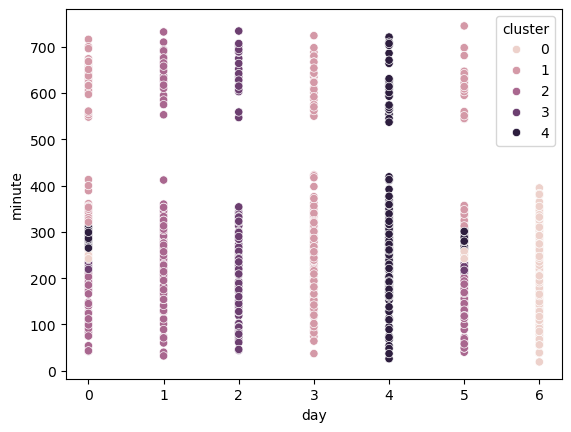

In [63]:
import seaborn as sns

TRANSACTIONS_WITH_CLUSTERS = SAMPLES.copy()
TRANSACTIONS_WITH_CLUSTERS['cluster'] = CLUSTERS

sns.scatterplot(data=TRANSACTIONS_WITH_CLUSTERS, x='day', y='minute', hue='cluster')

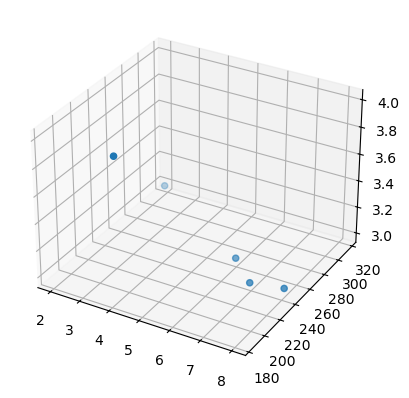

In [35]:
plot = plt.axes(projection='3d')
plot.scatter3D(CENTERS['month'], CENTERS['minute'], CENTERS['day'])

In [64]:
import itertools
from typing import Iterable

MINSUP = 0.1

def remove_infrequent_patterns(transactions: Iterable[frozenset[str]], patterns: list[frozenset[str]], threshold: int):
    counts = [0] * len(patterns)

    for transaction in transactions:
        for i, pattern in enumerate(patterns):
            if pattern.issubset(transaction):
                counts[i] += 1

    i = 0
    while i < len(patterns):
        if counts[i] < threshold:
            del patterns[i]
            del counts[i]
        else:
            i += 1

def get_candidates(F_k: list[frozenset[str]], k: int) -> set[frozenset[str]]:
    C_k_plus_1 = set()

    for i, p in enumerate(F_k):
        for q in F_k[i + 1:]:
            candidate = p.union(q)
            if len(candidate) != k + 1:
                continue
            all_subsets_of_candidate_are_frequent = True
            for subset in itertools.combinations(candidate, k):
                if set(subset) not in F_k:
                    all_subsets_of_candidate_are_frequent = False
                    break
            if not all_subsets_of_candidate_are_frequent:
                continue
            C_k_plus_1.add(candidate)

    return C_k_plus_1

def apriori(transactions: Iterable[frozenset[str]], items: frozenset[str], minsup: float) -> list[frozenset[str]]:
    threshold = minsup * len(transactions)

    # Start with singletons.
    F_1 = [frozenset([item]) for item in items]
    remove_infrequent_patterns(transactions, F_1, threshold)

    F = [F_1]

    for k in range(1, len(items)):
        C_k_plus_1 = get_candidates(F[-1], k)

        F_k_plus_1 = list(C_k_plus_1)
        remove_infrequent_patterns(transactions, F_k_plus_1, threshold)

        if not F_k_plus_1:
            break

        F.append(F_k_plus_1)

    return [pattern for F_k in F for pattern in F_k]

for i in range(len(CENTERS)):
    transactions_in_cluster = TRANSACTIONS_WITH_CLUSTERS.loc[TRANSACTIONS_WITH_CLUSTERS['cluster'] == i]
    items = frozenset(itertools.chain(*transactions_in_cluster['article']))
    frequent_patterns = apriori(transactions_in_cluster['article'], items, MINSUP)
    frequent_patterns.sort()
    print(f'Cluster {i}')
    for pattern in frequent_patterns:
        print(', '.join(pattern))
    print()

Cluster 0
COUPE
PAIN AU CHOCOLAT
BANETTE
BAGUETTE
TRADITIONAL BAGUETTE
CROISSANT

Cluster 1
COUPE
BANETTE
TRADITIONAL BAGUETTE

Cluster 2
COUPE
BANETTE
BAGUETTE
TRADITIONAL BAGUETTE

Cluster 3
COUPE
BANETTE
BAGUETTE
TRADITIONAL BAGUETTE

Cluster 4
COUPE
BAGUETTE
TRADITIONAL BAGUETTE

